In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from utils import *

In [18]:
full_data = openml.datasets.get_dataset(15).get_data()[0]
full_data.shape

(699, 10)

In [19]:
data, _ = train_test_split(full_data, train_size=200)

In [4]:
profile = ProfileReport(data, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 482 to 363
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Clump_Thickness        200 non-null    float64 
 1   Cell_Size_Uniformity   200 non-null    float64 
 2   Cell_Shape_Uniformity  200 non-null    float64 
 3   Marginal_Adhesion      200 non-null    float64 
 4   Single_Epi_Cell_Size   200 non-null    float64 
 5   Bare_Nuclei            198 non-null    float64 
 6   Bland_Chromatin        200 non-null    float64 
 7   Normal_Nucleoli        200 non-null    float64 
 8   Mitoses                200 non-null    float64 
 9   Class                  200 non-null    category
dtypes: category(1), float64(9)
memory usage: 15.9 KB


In [5]:
n_classes = data['Class'].unique().size

---
### CatBoostEncoder

In [7]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [8]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

In [9]:
best = exp.create_model('gbc')

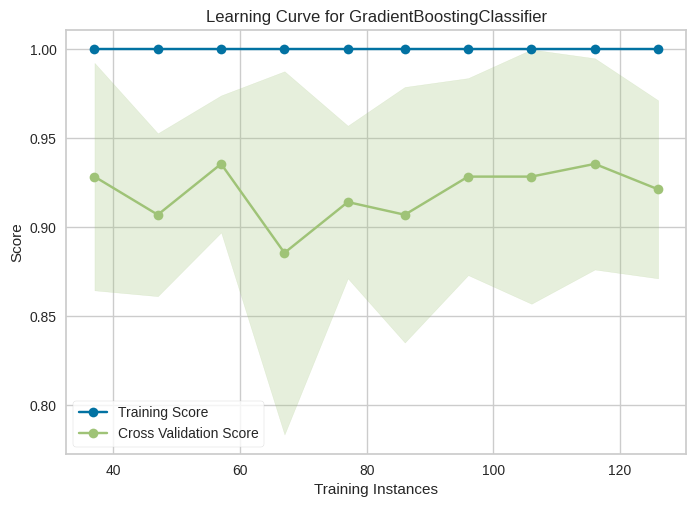

In [10]:
exp.plot_model(best, plot='learning')

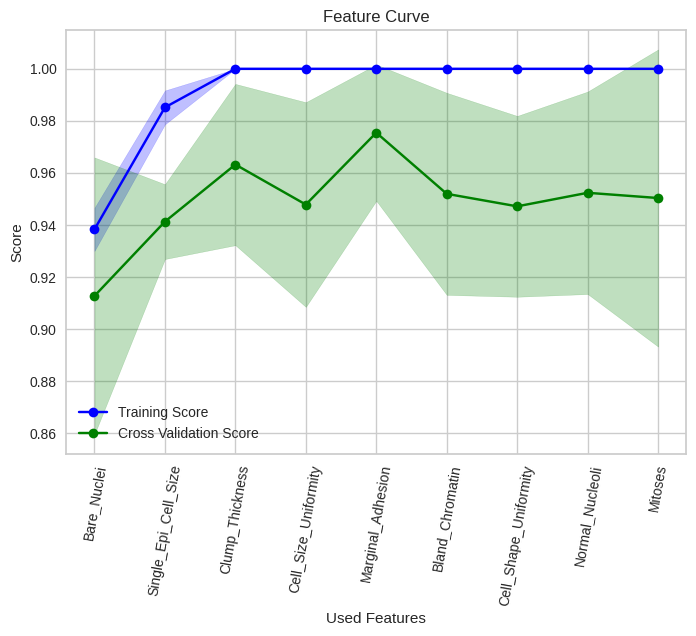

In [10]:
fc = FeatureCurve(best, exp.X_train_transformed, exp.y_train_transformed)
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 5.17 s, sys: 28.3 ms, total: 5.2 s
Wall time: 5.21 s


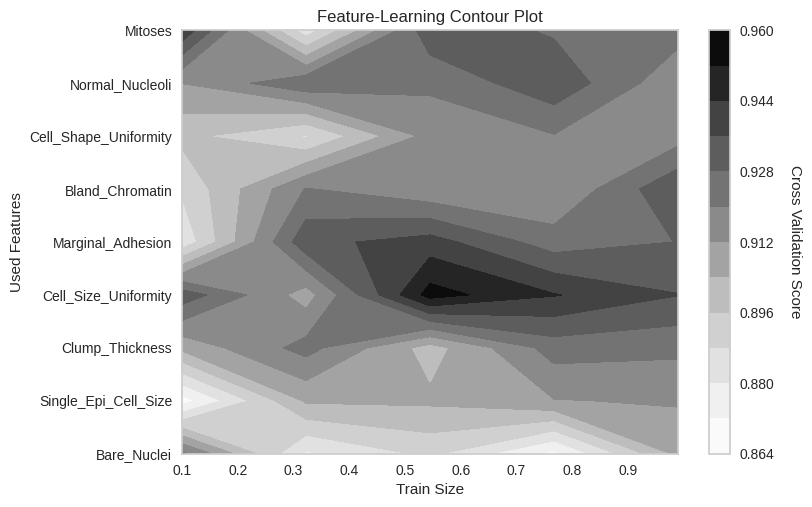

In [11]:
%%time
flc = FeatureLearningCurve(best, exp.X_train_transformed, exp.y_train_transformed, cv=3,
                           features_order=fc.features_order_, scoring=balanced_accuracy_score
)
flc.fit(exp.X_train_transformed, exp.y_train_transformed, exp.X_test_transformed, exp.y_test_transformed)

---
### TabEBM with CatBoostEncoder

In [17]:
from tabebm.TabEBM import TabEBM

In [18]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

In [19]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [20]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7333333333333334

In [21]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.7305061559507524

---
### Full data experiement

In [15]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [16]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

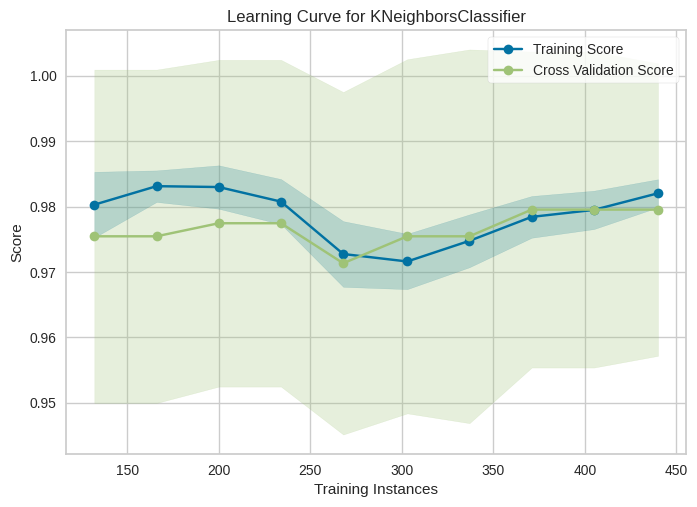

In [15]:
exp_full.plot_model(best_full, plot='learning')

In [12]:
fc.features_order_[:5]

Index(['Bare_Nuclei', 'Single_Epi_Cell_Size', 'Clump_Thickness',
       'Cell_Size_Uniformity', 'Marginal_Adhesion'],
      dtype='object')

In [20]:
exp_full = ClassificationExperiment()
exp_full.setup(
    data[[*fc.features_order_[:5], 'Class']],
    target='Class',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

In [21]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)